In [ ]:
cd ./Project/femcode(DL_executed)/cont_ver2

[Errno 2] No such file or directory: './Project/femcode(DL_executed)/cont_ver2'
/content


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
import numpy as np
import random
random.seed(99)
def append_data(data):
    num = random.randint(1,5)
    for _ in range(num):

        pos_x = random.randint(0, 19)
        pos_y = random.randint(0, 19)
        size_x = random.randint(1, 7)
        size_y = random.randint(1, 7)
        mask = np.full((size_x,size_y),5)
        #print(pos_x-size_x,pos_x,pos_y-size_y,pos_y,mask)
        if ((pos_x + size_x) < 19) and ((pos_y + size_y)<19):
            data[pos_x:pos_x+size_x,pos_y:pos_y+size_y] = mask
        else:
            if ((pos_x + size_x) > 19):
                a = pos_x-size_x
                b = pos_x
            else:
                a = pos_x
                b = pos_x+size_x
            if ((pos_y + size_y)>19):
                c = pos_y-size_y
                d = pos_y
            else:
                c = pos_y
                d = pos_y+size_y
            data[a:b,c:d] = mask
#             data[max(0, pos_x-size_x):min(20, pos_x), max(0, pos_y-size_y):min(20, pos_y)] = mask
    return data


In [ ]:
#Don't Run
# Read content of original .dat file
with open('prop.dat', 'r') as original_file:
    original_content = original_file.readlines()

# Generate or load your 400x1 matrix
# For demonstration purposes, let's generate a random matrix

# Define function to modify content
def modify_content(content,matrix):
     modified_content = []  # Create an empty list to store modified content
    modified_content.append(content[0])  # Append the first line as it is
    # Iterate through lines 2 to 401 and replace them with values from the matrix
    for i in range(1, 402):  # Assuming lines 2 to 402 need modification
        if i==401:
             modified_content.append(str(0.33) + '\n')
        else:
             modified_content.append(str(matrix[i - 1]) + '\n')  # Subtract 1 to match zero-based indexing of matrix
    # Append the rest of the lines after line 401
    modified_content.extend(content[402:])
    return modified_content


# Modify content of .dat file
for i in range(1000):
    matrix = np.full((20, 20), 70000000000)
    mat=append_data(matrix)
    data=mat.reshape(400)
    modified_content = modify_content(original_content, data)

# Write modified content to new .dat file
    with open(f'prop{i}.dat', 'w') as output_file:
        output_file.writelines(modified_content)

print("File modified successfully.")


FileNotFoundError: [Errno 2] No such file or directory: 'prop.dat'

In [2]:
import numpy as np
displacement_array=np.zeros((1000,1681))
for i in range(1000):
    with open(f'/content/drive/MyDrive/femcode(DL_executed)(updated)/femcode(DL_executed)/cont_ver2/displacement{i}', 'r') as file:
          # Read all lines

        lines = file.readlines()

    # Initialize an empty list to store the last elements
    last_elements = []

    # Iterate over each line
    for line in lines:
        # Split the line by spaces and get the last element
        last_element = float(line.strip().split()[-1])
        # Append the last element to the list
        last_elements.append(last_element)

    # Convert the list to a NumPy array
    last_elements_array = np.array(last_elements)
    displacement_array[i]=last_elements_array
displacement_array.shape

(1000, 1681)

In [3]:
!pip install keras_tuner

## Genrating Model


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#for neural network
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
from keras.models import Sequential, Model, load_model
from keras.utils import plot_model
from keras.layers import Reshape, Dense, Input
from sklearn.model_selection import train_test_split
from keras import regularizers
import keras_tuner as kt
from keras.layers import RepeatVector
from keras.layers import Flatten
from sklearn.preprocessing import StandardScaler


In [5]:
X = np.random.rand(1000, 400)
for i in range(1000):
    matrix = np.full((20, 20), 70000000000)
    mat=append_data(matrix)
    data=mat.reshape(400)
    X[i]=data
X[1].shape
x_range = np.arange(1, 21)  # from 1 to 20
y_range = np.arange(1, 21)  # from 1 to 20

# Create meshgrid of x and y coordinates
a, b = np.meshgrid(x_range, y_range)

# Flatten the meshgrid and reverse the positions of x and y
coordinates = np.column_stack((b.ravel(), a.ravel()))

# Repeat the coordinates 1000 times to create a 3D array
coordinates_3d = np.tile(coordinates[ np.newaxis, :,:], (1000, 1, 1))

coordinates_3d.shape

(1000, 400, 2)

In [6]:
y = displacement_array*10000  # scaling the output so it will give useful results
num_samples = coordinates_3d.shape[0]
dummy_target = np.zeros(num_samples)
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train2, X_test2, _, _ = train_test_split(coordinates_3d, dummy_target, test_size=0.2)
input_shape=X_train.shape[1:]
output_shape=y_train.shape[1]
input_shape,output_shape
input_shape2=X_train2.shape

# DeepOnet


In [7]:
S1 = StandardScaler()
S2 = StandardScaler()
S3 = StandardScaler()
X_train = S1.fit_transform(X_train)
X_test = S1.transform(X_test)
X_train2[:,:,0] = S2.fit_transform(X_train2[:,:,0])
X_test2[:,:,0] = S2.transform(X_test2[:,:,0])
X_train2[:,:,1] = S3.fit_transform(X_train2[:,:,1])
X_test2[:,:,1] = S3.transform(X_test2[:,:,1])
initalizer = keras.initializers.HeNormal # relu

In [38]:
initalizer = keras.initializers.GlorotNormal# tanh
input1 = Input(input_shape, name="Input_1")
input2 = Input((400,2), name="Input_2")
# Reshape input2 to match the shape of input1 along the concatenation axis
flatten_input2 = Flatten()(input2)

# Add layers for input 1
x1 = Dense(800, activation='relu', kernel_initializer=initalizer)(input1)
x1 = Dense(1600, activation='relu', kernel_initializer=initalizer)(x1)
x1 = Dense(2400, activation='relu', kernel_initializer=initalizer)(x1)

x1 = Dense(2000, activation='relu', kernel_initializer=initalizer)(x1)
x1 = Dense(1200, activation='relu', kernel_initializer=initalizer)(x1)

# Add layers for input 2
x2 = Dense(1600, activation='relu', kernel_initializer=initalizer)(flatten_input2)
x2 = Dense(2000, activation='relu', kernel_initializer=initalizer)(x2)
x2 = Dense(2400, activation='relu', kernel_initializer=initalizer)(x2)

x2 = Dense(2000, activation='relu', kernel_initializer=initalizer)(x2)
x2 = Dense(1600, activation='relu', kernel_initializer=initalizer)(x2)

# Merge outputs from both branches
merged = layers.concatenate([x1, x2])

# Output layer with size 1681
outputs = Dense(1681)(merged)

# Create the model
model2 = Model(inputs=[input1, input2], outputs=outputs)
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input_2 (InputLayer)        [(None, 400, 2)]             0         []                            
                                                                                                  
 Input_1 (InputLayer)        [(None, 400)]                0         []                            
                                                                                                  
 flatten_3 (Flatten)         (None, 800)                  0         ['Input_2[0][0]']             
                                                                                                  
 dense_37 (Dense)            (None, 800)                  320800    ['Input_1[0][0]']             
                                                                                            

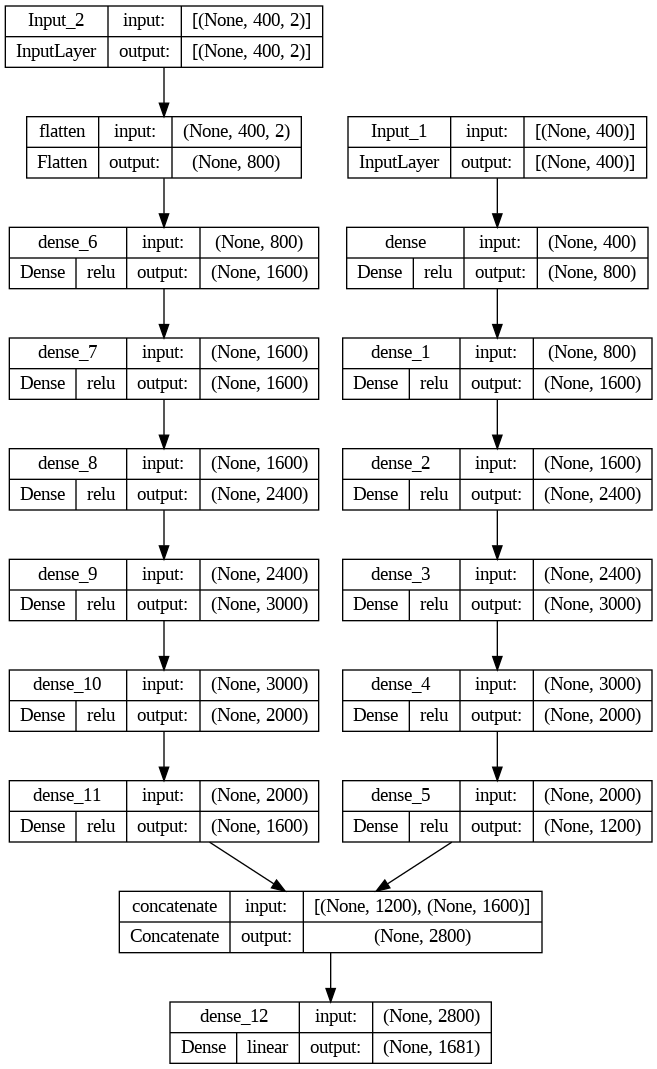

In [9]:
plot_model(model2, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [10]:
X_train2.shape,X_test2.shape

((800, 400, 2), (200, 400, 2))

In [39]:
optim = keras.optimizers.Adam(0.0001)
model2.compile(optimizer=optim, loss='mse')

history = model2.fit([X_train,X_train2], y_train, epochs=10, validation_data=([X_test,X_test2], y_test))

Epoch 1/10
25/25 [==============================] - 5s 24ms/step - loss: 17.1602 - val_loss: 4.5190
Epoch 2/10
25/25 [==============================] - 0s 14ms/step - loss: 4.8725 - val_loss: 3.2263
Epoch 3/10
25/25 [==============================] - 0s 14ms/step - loss: 3.8791 - val_loss: 4.2133
Epoch 4/10
25/25 [==============================] - 0s 14ms/step - loss: 3.8126 - val_loss: 3.0875
Epoch 5/10
25/25 [==============================] - 0s 14ms/step - loss: 2.9096 - val_loss: 3.4231
Epoch 6/10
25/25 [==============================] - 0s 14ms/step - loss: 2.7103 - val_loss: 3.1218
Epoch 7/10
25/25 [==============================] - 0s 14ms/step - loss: 1.9525 - val_loss: 2.9931
Epoch 8/10
25/25 [==============================] - 0s 14ms/step - loss: 1.3264 - val_loss: 3.1431
Epoch 9/10
25/25 [==============================] - 0s 14ms/step - loss: 0.9903 - val_loss: 3.0281
Epoch 10/10
25/25 [==============================] - 0s 14ms/step - loss: 0.8267 - val_loss: 2.9930


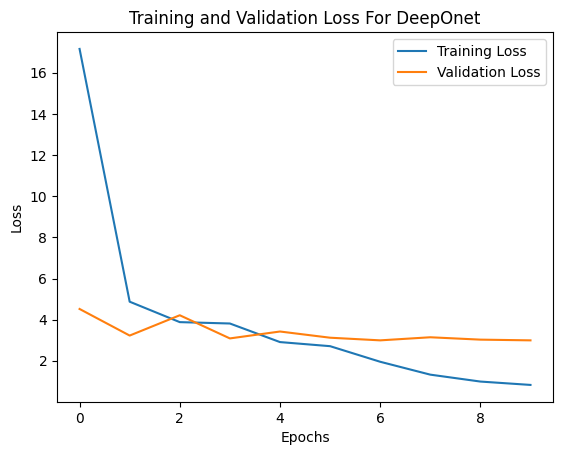

In [40]:
# Plot epochs vs. loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss For DeepOnet')
plt.legend()
plt.show()

In [38]:
model2.predict([X_test,X_test2])

7/7 [==============================] - 0s 4ms/step


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [39]:
y_test

array([[ 0.      ,  0.      ,  0.      , ..., 14.41415 , 14.51099 ,
        14.6444  ],
       [ 0.      ,  0.      ,  0.      , ...,  7.161864,  7.258092,
         7.391667],
       [ 0.      ,  0.      ,  0.      , ...,  7.419491,  7.515719,
         7.649291],
       ...,
       [ 0.      ,  0.      ,  0.      , ...,  5.667238,  5.763463,
         5.897039],
       [ 0.      ,  0.      ,  0.      , ...,  7.980959,  8.077159,
         8.210724],
       [ 0.      ,  0.      ,  0.      , ..., 13.21575 , 13.31198 ,
        13.44558 ]])

# ANN


In [26]:
# Define the ANN model
model1 = Sequential()
model1.add(Dense(400, input_shape=input_shape, activation='relu', name = 'Input', kernel_initializer=initalizer)) #input layer
model1.add(Dense(1000, activation='relu', kernel_initializer=initalizer))
model1.add(Dense(1600, activation='relu', kernel_initializer=initalizer))
model1.add(Dense(2400, activation='relu', kernel_initializer=initalizer))
model1.add(Dense(3000, activation='relu', kernel_initializer=initalizer))
model1.add(Dense(2400, activation='relu', kernel_initializer=initalizer))
model1.add(Dense(2000, activation='relu', kernel_initializer=initalizer))
model1.add(Dense(1681, name = 'Output')) # output layer
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (Dense)               (None, 400)               160400    
                                                                 
 dense_17 (Dense)            (None, 1000)              401000    
                                                                 
 dense_18 (Dense)            (None, 1600)              1601600   
                                                                 
 dense_19 (Dense)            (None, 2400)              3842400   
                                                                 
 dense_20 (Dense)            (None, 3000)              7203000   
                                                                 
 dense_21 (Dense)            (None, 2400)              7202400   
                                                                 
 dense_22 (Dense)            (None, 2000)             

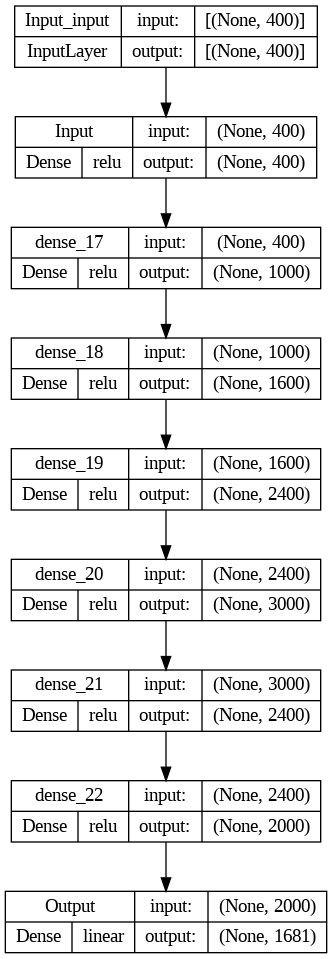

In [27]:
plot_model(model1, show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [31]:
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mse' )

history=model1.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
25/25 [==============================] - 3s 22ms/step - loss: 221.4350 - val_loss: 24.0078
Epoch 2/10
25/25 [==============================] - 0s 12ms/step - loss: 40.4664 - val_loss: 3.9220
Epoch 3/10
25/25 [==============================] - 0s 12ms/step - loss: 6.8764 - val_loss: 4.2771
Epoch 4/10
25/25 [==============================] - 0s 12ms/step - loss: 5.4059 - val_loss: 6.0622
Epoch 5/10
25/25 [==============================] - 0s 12ms/step - loss: 6.1668 - val_loss: 8.3596
Epoch 6/10
25/25 [==============================] - 0s 14ms/step - loss: 4.8099 - val_loss: 3.1822
Epoch 7/10
25/25 [==============================] - 0s 15ms/step - loss: 2.8402 - val_loss: 4.0197
Epoch 8/10
25/25 [==============================] - 0s 14ms/step - loss: 2.4128 - val_loss: 3.0022
Epoch 9/10
25/25 [==============================] - 0s 15ms/step - loss: 2.4341 - val_loss: 4.9247
Epoch 10/10
25/25 [==============================] - 0s 13ms/step - loss: 2.2757 - val_loss: 3.8612


In [1]:
test_loss= model1.evaluate(X_test, y_test)
print("Test Loss FOR ANN:", test_loss)


NameError: name 'model1' is not defined

In [32]:
# FOR ANN
model1.predict(X_test)

7/7 [==============================] - 0s 3ms/step


array([[-0.04480736, -0.12804836,  0.04999661, ...,  6.8914566 ,
         6.9320283 ,  7.0880456 ],
       [-0.10278296, -0.20266807,  0.06799543, ..., 12.008759  ,
        12.027733  , 12.257994  ],
       [-0.07187152, -0.16343889,  0.05670393, ...,  8.627366  ,
         8.659404  ,  8.841123  ],
       ...,
       [-0.05123809, -0.13325232,  0.05823982, ..., 10.443156  ,
        10.47608   , 10.68141   ],
       [-0.14568543, -0.26829395,  0.0731923 , ..., 13.024769  ,
        13.033874  , 13.2835    ],
       [-0.08441925, -0.17755523,  0.06273252, ..., 10.881477  ,
        10.905769  , 11.118708  ]], dtype=float32)

In [33]:
y_test

array([[ 0.      ,  0.      ,  0.      , ...,  6.752358,  6.84864 ,
         6.982224],
       [ 0.      ,  0.      ,  0.      , ...,  7.736916,  7.833137,
         7.966711],
       [ 0.      ,  0.      ,  0.      , ...,  6.514533,  6.610765,
         6.744342],
       ...,
       [ 0.      ,  0.      ,  0.      , ..., 12.89767 , 12.9942  ,
        13.12775 ],
       [ 0.      ,  0.      ,  0.      , ..., 12.21668 , 12.31295 ,
        12.4465  ],
       [ 0.      ,  0.      ,  0.      , ..., 11.31705 , 11.41336 ,
        11.54686 ]])

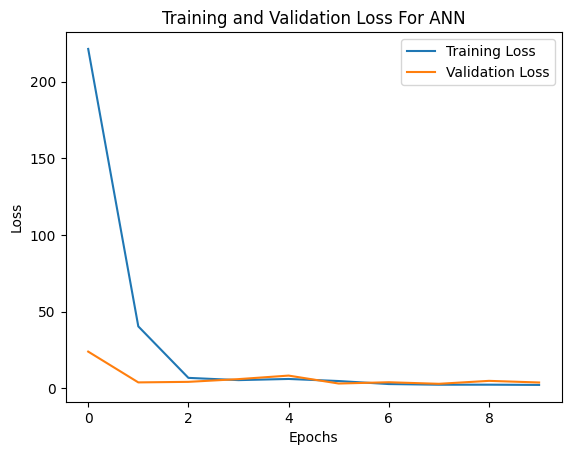

In [35]:
# Plot epochs vs. loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss For ANN')
plt.legend()
plt.show()